# Multi-layer networks

In the previous unit, we have used one-layer dense neural network to classify handwritten digits. Now let's see if adding more layers will give us better performance in terms of accuracy.

Let's start by importing things and loading data:

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

# In this tutorial, we will be training a lot of models. In order to use GPU memory cautiously,
# we will set tensorflow option to grow GPU memory allocation when required.
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [2]:
# Pre-fetch the data when running in sandbox environment
!mkdir -p ~/.keras/datasets
!wget -P ~/.keras/datasets -q https://github.com/MicrosoftDocs/tensorflowfundamentals/raw/main/data/mnist.npz

In [3]:
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

## Multi-layer perceptron

In a multi-layer network, we will add one or more **hidden layers**.

![An image showing a multi-layer network with a hidden layer between the input layer and the output layer.](notebooks/images/dense-multilayer-network.png)

This layer may contain any number of neurons, which will affect how powerful our neural network it, i.e. how many parameters will it have. The more parameters there are in the network - the more data we need to train it.

However, _more_ is not always _better_. A number of parameters of a neural network should be chosen depending on the dataset size, to prevent **overfitting**.

Our network layer structure will look like this:

![An image showing the network layer structure as it's broken down into layers.](notebooks/images/multilayer-network-layers.png)

An important thing to note here is the non-linear activation function layer, called **ReLU**. It is important to introduce those non-linear activation functions, because they are one of the reasons neural networks achieve high expressive power. Indeed, it can be demonstrated mathematically that if a network consisted just of a series of linear layers, it would essentially be equivalent to one linear layer. Thus inserting non-linear functions in between layers is important!

Here's how two of the most frequently used activation functions look:

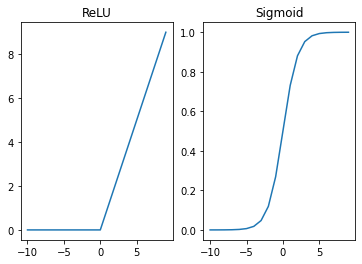

In [4]:
def plot_function(f,name=''):
    plt.plot(range(-10,10), [f(tf.constant(x,dtype=tf.float32)) for x in range(-10,10)])
    plt.title(name)

plt.subplot(121)
plot_function(tf.nn.relu,'ReLU')
plt.subplot(122)
plot_function(tf.nn.sigmoid,'Sigmoid')


## Another Way of Defining a Model

Our network can be defined in Keras in the following way. We will modified the approach by initializing the `model` object first, and then adding all layers one by one:

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(28,28)))
model.add(keras.layers.Dense(100))     # 784 inputs, 100 outputs
model.add(keras.layers.ReLU())         # Activation Function
model.add(keras.layers.Dense(10))      # 100 inputs, 10 outputs

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
re_lu (ReLU)                 (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


## Sparse Categorical Crossentropy with Softmax

You have probably noticed that we did not use **softmax** as the activation function after the last layer. Keras allows us to combine the activation function together with loss function which means we just need to make sure and specify `from_logits=True` flag when defining loss function in `compile`.

Also, in most of the cases when we have a multi-class classification, our dataset contains the number of class, which we then convert to one-hot encoding. However, this uses quite a lot of extra memory, and we can in fact define the loss function in such a way that it will expect the **number of class**, instead of the corresponding one-hot vector. This loss function is called **sparse categorical cross-entropy**.


In [6]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])

Let's fit the model and make sure it gives good results:

In [7]:
hist = model.fit(x_train,y_train, validation_data=(x_test,y_test), epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2672 - acc: 0.9245 - val_loss: 0.1427 - val_acc: 0.9555
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1284 - acc: 0.9627 - val_loss: 0.1073 - val_acc: 0.9678
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0956 - acc: 0.9719 - val_loss: 0.1006 - val_acc: 0.9719
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0766 - acc: 0.9778 - val_loss: 0.0898 - val_acc: 0.9723
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0665 - acc: 0.9809 - val_loss: 0.0878 - val_acc: 0.9765


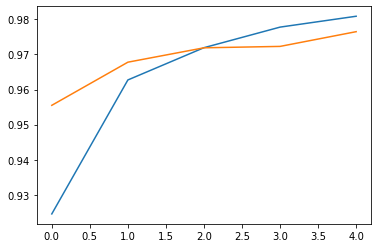

In [8]:
for x in ['acc','val_acc']:
    plt.plot(hist.history[x])

Please note the following:
 * This network is more expressive than the one layered perceptron we have trained in the previous unit. Thus it achieves a much higher training accuracy and given sufficiently large number of parameters - it can get to almost 100% if we train for long enough. If not - we can increase the number of neurons in the hidden layer.
 * Even if we achieve very high training accuracy - validation accuracy typically does not go above a certain point. Once the validation accuracy stops increasing - it means that the model has reached it's ability to generalize, and further training is likely to result in **overfitting**.

## Overfitting

> **Overfitting** is a very important concept to understand. It means that our model fits the training data very well, but does not further generalize well on unseen data. Often overfitting results in validation accuracy starting to increase, which means that model is becoming worse with further training.

What you can do to overcome overfitting:
* Make the model less powerful by decreasing the number of parameters
* Increase the number of training examples, maybe by using some clever approaches such as **data augmentation**
* Stop training as soon as validation accuracy starts dropping 

## Shorter Model Definitions

In many cases a model consists of a number of layers, and activation functions in between those layers. To make model definitions shorter, Keras allows us to specify activation function that follows the layer right inside the layer definition, like this: 

In [9]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(28,28)))
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dense(10,activation=None))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


As you can see, this model is equivalent to the one above, but the definition looks neater.

## Takeaway

Multi-level networks can achieve higher accuracy than single-layer perceptron, however, they are not perfect for computer vision tasks. In images, there are some structural patterns that can help us classify an object regardless of it's position in the image, but perceptrons do not allow us to extract those patterns and look for them selectively. In the next unit we will focus on a special type of neural networks that can be used effectively for computer vision tasks.